In [15]:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import yfinance as yf
import sklearn as sk
from sklearn import gaussian_process as gp
from sklearn.gaussian_process.kernels import DotProduct, RBF, WhiteKernel, Matern

# Plot the results


In [16]:
def SMA(arr, n=10):
    """Compute the moving average of an array."""
    res = [sum(arr[i-n:i])/n for i in range(n, len(arr))]
    std = [np.std(arr[i-n:i]) for i in range(n, len(arr))]
    return res, std 

def sparse(arr, n=10, s=2):
    """Compute the sparse average of an array."""
    l = len(arr)
    res = []
    avg_ind = []
    for i in range(0, l-s*n, n):
        res.append(float(arr[i])) #Append float instead of np array, mostly for plotting
        avg_ind.append(i+n)
    return res, avg_ind

In [17]:
start_date = '2021-01-01'
end_date = '2025-04-10'
index = 'AAPL'  # Example stock symbol, change as needed
# Get the stock data
stock = yf.download(index, start=start_date, end=end_date)

data = pd.DataFrame.to_numpy(stock['Close'])
data = data-data[0]
days = np.atleast_2d(np.arange(len(data))).T

#find the moving average
day_avg = 15
SMA_data, std_data = SMA(data, n=day_avg)

# Downsample the data, s ensures there is unsampled data for prediction
sparse_data, sparse_days = sparse(SMA_data, n=day_avg, s=4)
sparse_std, _ = sparse(std_data, n=day_avg, s=4)
sparse_days = np.atleast_2d(sparse_days).T

[*********************100%***********************]  1 of 1 completed
/var/folders/hq/gsdbcm4x4w90mhd9khtb6yzh0000gn/T/ipykernel_30214/2012240568.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res.append(float(arr[i])) #Append float instead of np array, mostly for plotting


Let's discuss the kernels a bit:
-A dot product kenrel produces a polynomial type of kernel (i.e. the S&P500 type of growth)

-RBF is the typical correlation kernel following a GP

-In a Matern kernel, the data are correlated inversly to their distance. If you think of the random walk it's striaghtforward why we want this.

-A white kernel introduces the expected noise you have from this type of data


Now let's discuss addition vs multiplication of kernels:

Roughly speaking multiplying corresponds to an 'AND' operation and adding the kernels to an 'OR' operation. Here it is very well explained why:
https://www.cs.toronto.edu/~duvenaud/cookbook/

The design choice is to model the long term growth (or decline) of the asset with the dot product and then use RBF or Matern for the intermidiate flactuations.

In [ ]:
#Our lower bound for the noise is the std of the data
lower_bound = np.mean(sparse_std)
# Create the Gaussian Process model
kernel = 0.3*DotProduct()*(0.3*RBF(length_scale_bounds=(1e-1, 100.0),) + 0.3 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 100), nu=1.5)) + 0.1*WhiteKernel(
    noise_level=lower_bound, noise_level_bounds=(lower_bound, 1e1))
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)

# Fit the model to the data
model.fit(sparse_days, sparse_data)

# Make predictions
predictions = model.predict(days, return_std=True)

# Get the dates for the x-axis
dates = pd.date_range(start=start_date, end=end_date)

/Users/nikolashadjiantoni/miniconda3/envs/mp/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


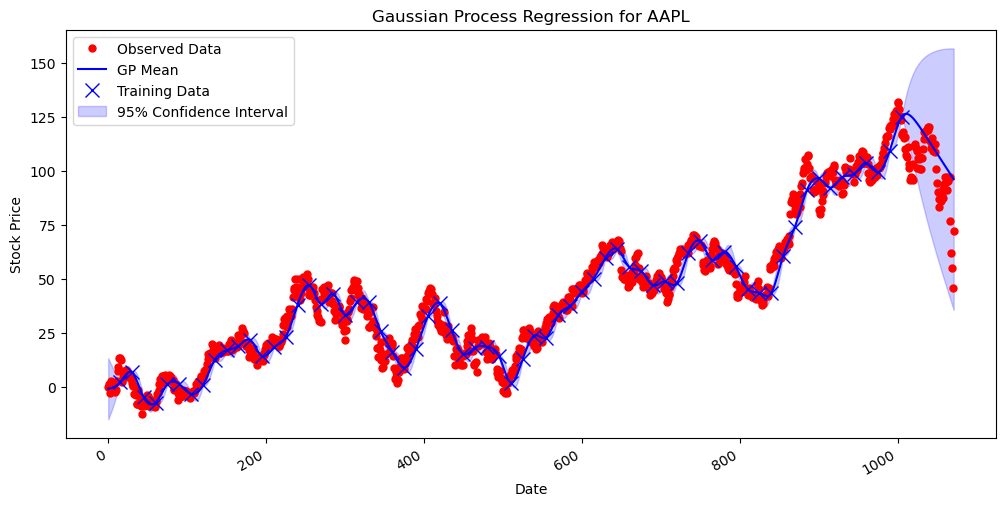

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(days, data, 'r.', markersize=10, label='Observed Data')
plt.plot(days, predictions[0], 'b-', label='GP Mean')
plt.plot(sparse_days, sparse_data, 'bx', markersize=10, label='Training Data')
plt.fill_between(np.arange(len(data)), predictions[0] - 1.96 * predictions[1], predictions[0] + 1.96 * predictions[1], alpha=0.2, color='blue', label='95% Confidence Interval')
plt.title(f'Gaussian Process Regression for {index}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate() 
plt.show()

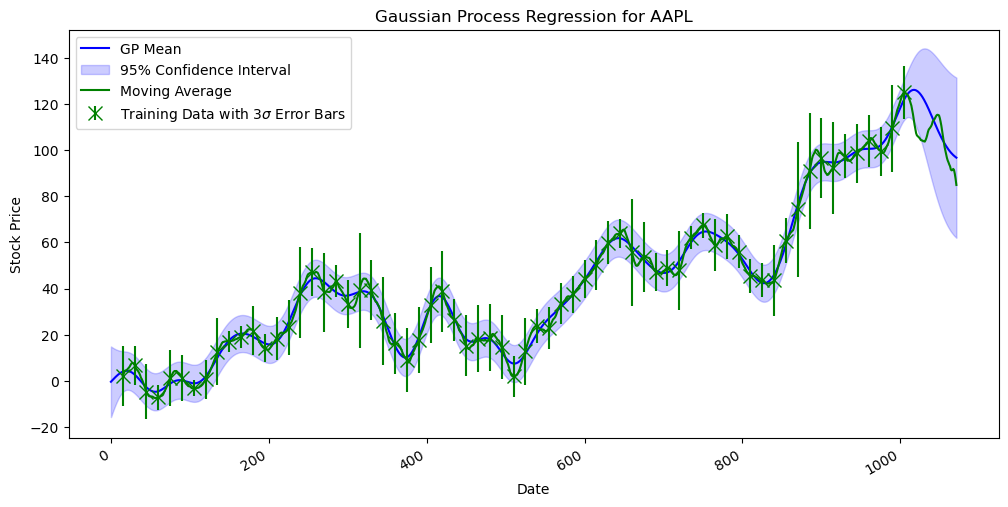

In [49]:
plt.figure(figsize=(12, 6))
# plt.plot(days, data, 'r.', markersize=10, label='Observed Data')
plt.plot(days, predictions[0], 'b-', label='GP Mean')
plt.fill_between(np.arange(len(data)), predictions[0] - 1.96 * predictions[1], predictions[0] + 1.96 * predictions[1], alpha=0.2, color='blue', label='95% Confidence Interval')
plt.errorbar(sparse_days, sparse_data, yerr=3*np.array(sparse_std), fmt='gx', markersize=10, label='Training Data with 3$\sigma$ Error Bars')
plt.plot(days[day_avg:], SMA_data, 'g-', label='Moving Average')
plt.title(f'Gaussian Process Regression for {index}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate() 
plt.show()

In [51]:
print('Some important model metrics:')
print(f"Noise Level: {model.kernel_.k2.k2.get_params()['noise_level']}")
print(f"Length Scale: {model.kernel_.k1.get_params()['k2']}")
print(f"Log Marginal Likelihood: {model.log_marginal_likelihood(model.kernel_.theta)}")


Some important model metrics:
Noise Level: 0.00011234536266275639
Length Scale: 0.00497**2 * Matern(length_scale=0.748, nu=1.5)
Log Marginal Likelihood: -236.30567284546626
